In [1]:
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fast')

In [2]:
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage


In [3]:
df = pd.read_csv("ASM_Vapor_Spectra.csv")

In [4]:
df['Raw_Spectra_Intensity'] = df['Raw_Spectra_Intensity'].apply(json.loads)
df['Raw_Spectra_Intensity'] = df['Raw_Spectra_Intensity'].apply(np.array)
df['Normalized_Spectra_Intensity'] = df['Raw_Spectra_Intensity'].apply(lambda x: x/max(x))

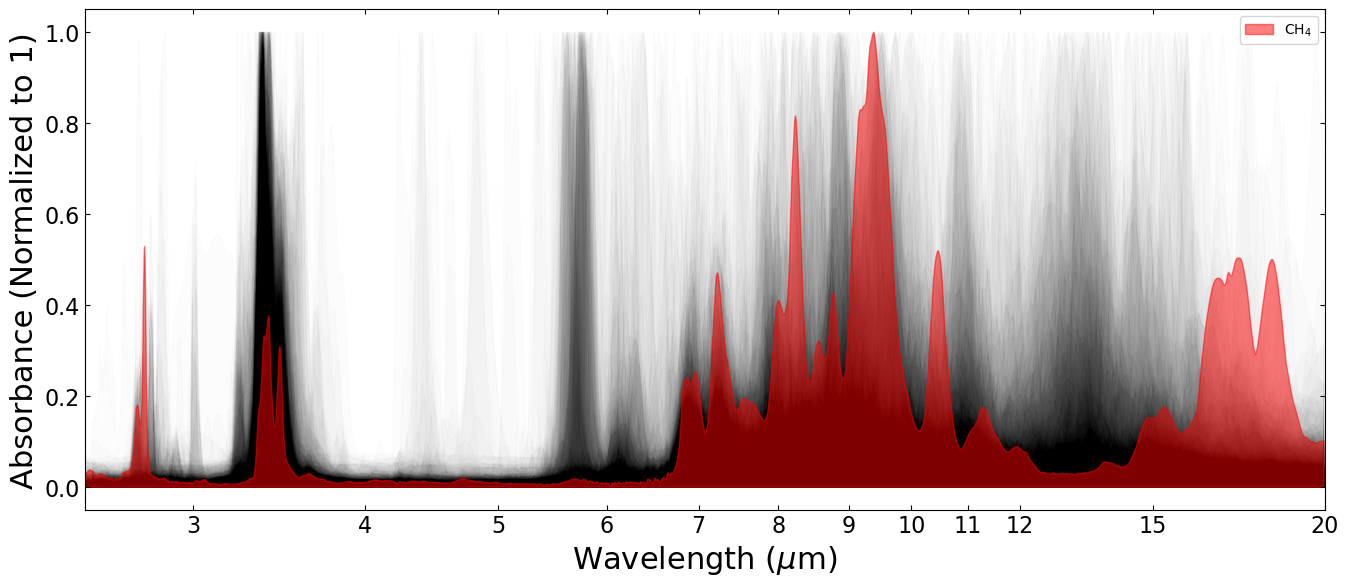

In [5]:
fig, ax = plt.subplots(figsize=(16, 6.5))   

wavenumber = np.arange(4000,500,-1)
wavelength = 10000/wavenumber #in micron


# This is a very slow part of the code that need optimization
target_spectra = []
for smiles, spectra in df[['SMILES','Normalized_Spectra_Intensity']].values:    
    if smiles == 'C':
        continue
        target_spectra = spectra
    else:
        ax.fill_between(wavelength, 0, spectra,color="k",alpha=0.01)
    
ax.fill_between(wavelength, 0, spectra,color="r",alpha=0.5, label="CH$_4$")


# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Set major and minor ticks manually
major_ticks = [3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 20]

ax.set_xticks(major_ticks, minor=False) 

ax.set_xlim([2.5,20])


ax.tick_params(axis="x",labelsize=16)
ax.tick_params(axis="y",labelsize=16)  

ax.set_xticks([3,4,5,6,7,8,9,10,11,12,15,20])
ax.set_xticklabels(["3","4","5","6","7","8","9","10","11","12","15","20"])

ax.tick_params(direction="in",
                labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                bottom=True, top=True, left=True, right=True) 

ax.set_xlabel("Wavelength ($\mu$m)", fontsize=22)
ax.set_ylabel("Absorbance (Normalized to 1)", fontsize=22)


plt.legend()
plt.show()


In [60]:
data = np.array(df['Normalized_Spectra_Intensity'].tolist())

In [61]:
dist_mat = squareform(pdist(data))

In [64]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,"ward")

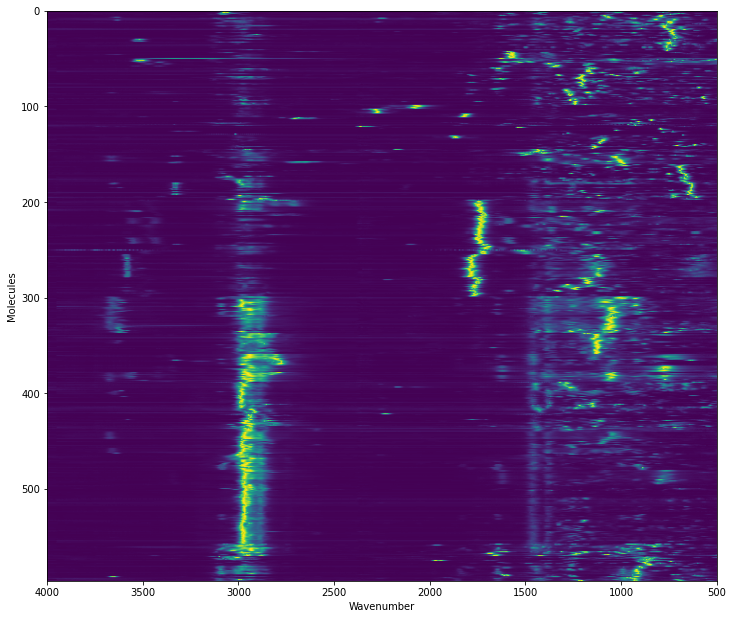

In [71]:
fig, ax = plt.subplots(figsize=(12, 12)) 


ratio = int(len(data[0])/len(data))

plt.imshow(np.array(data)[res_order], aspect=ratio,extent=[4000,500,len(ordered_dist_mat),0])
plt.xlabel("Wavenumber")
plt.ylabel("Molecules")
plt.show()